In [1]:
import numpy as np
import pandas as pd
import pathlib
import matplotlib as mpl
import matplotlib.pyplot as plt
import sys
import os.path

cwd = pathlib.Path().resolve()
src = cwd.parent
root = src.parent
sys.path.append(str(src))
sys.path.append(str(root))

In [2]:
from superflexpy.implementation.elements.gr4j import BaseElement, UnitHydrograph1, UnitHydrograph2, FluxAggregator 
from superflexpy.implementation.elements.gr4j import InterceptionFilter, ProductionStore, RoutingStore
from superflexpy.implementation.elements.structure_elements import Transparent, Splitter, Junction
from superflexpy.implementation.root_finders.pegasus import PegasusPython
from superflexpy.implementation.numerical_approximators.implicit_euler import ImplicitEulerPython
from superflexpy.framework.unit import Unit
from superflexpy.framework.node import Node
from superflexpy.framework.network import Network
from utils.precipitation_evaporation import *

In [3]:
x1, x2, x3, x4 = (50.0, 0.1, 20.0, 3.5) 

#x1 = max capacity of production storage [mm]
#x2 = groundwater exchange coefficient [mm]
#x3 = max capacity of routing storage [mm]
#x4 = time base of UH1 [days]

root_finder = PegasusPython()  # Use the default parameters
numerical_approximation = ImplicitEulerPython(root_finder)

interception_filter = InterceptionFilter(id='ir')

production_store = ProductionStore(parameters={'x1': x1, 'alpha': 2.0,
                                               'beta': 5.0, 'ni': 4/9},
                                   states={'S0': 10.0},
                                   approximation=numerical_approximation,
                                   id='ps')
# alpha= exponent in the evapotranspiration (Es) and main outflow (Ps) equations. Suggested value: 2.0
# beta : exponent in the percolation equation. Suggested value: 5.0.
# ni : coefficient in the percolation equation. Suggested value: 4/9.
# S0 :  initial storage of the reservoir.
        
                      
splitter = Splitter(weight=[[0.9], [0.1]],
                    direction=[[0], [0]],
                    id='spl')
# weight: determines which part goes donwnstream
# direction: where each input influx goes in the output elements

unit_hydrograph_1 = UnitHydrograph1(parameters={'lag-time': x4},
                                    states={'lag': None},
                                    id='uh1')
#             - lag_time : total length (base) of the lag function. It is equal to x4 in GR4J

unit_hydrograph_2 = UnitHydrograph2(parameters={'lag-time': 2*x4},
                                    states={'lag': None},
                                    id='uh2')
#             - lag_time : total length (base) of the lag function. It is equal to 2*x4 in GR4J
routing_store = RoutingStore(parameters={'x2': x2, 'x3': x3,
                                         'gamma': 5.0, 'omega': 3.5},
                             states={'S0': 10.0},
                             approximation=numerical_approximation,
                             id='rs')
# gamma : exponent in the main outflow (Qr) equation. Suggested value: 5
# omega : Exponent in the exchange flux (F) equation. Suggested value: 3.5


transparent = Transparent(id='tr')

junction = Junction(direction=[[0, None],  # First output
                               [1, None],  # Second output
                               [None, 0]], # Third output
                    id='jun')
# direction: determines which input element goes in the output element

flux_aggregator = FluxAggregator(id='fa')
"""This class calculates the final output of GR4J, aggregating the output
    of the routing store with the one of the unit hydrograph 2 and subtracting
    the loss F
        input : list(numpy.ndarray)
            List containing the input fluxes of the element. It contains 3
            fluxes and the order must be the following:
            1. Outflow routing store (Qr)
            2. Exchange flux (F)
            3. Outflow UH2 (Q2_out)
        """

'This class calculates the final output of GR4J, aggregating the output\n    of the routing store with the one of the unit hydrograph 2 and subtracting\n    the loss F\n        input : list(numpy.ndarray)\n            List containing the input fluxes of the element. It contains 3\n            fluxes and the order must be the following:\n            1. Outflow routing store (Qr)\n            2. Exchange flux (F)\n            3. Outflow UH2 (Q2_out)\n        '

In [4]:
evaporation, precipitation = precipitation_evaporation(8, 0.2, season = True, plot = False)

In [5]:
model = Unit(layers=[[interception_filter],
                     [production_store],
                     [splitter],
                     [unit_hydrograph_1, unit_hydrograph_2],
                     [routing_store, transparent],
                     [junction],
                     [flux_aggregator]],
             id='model')

In [6]:
model.reset_states()
model.set_timestep(1.0)
model.set_input([evaporation,precipitation])
output = model.get_output()[0]

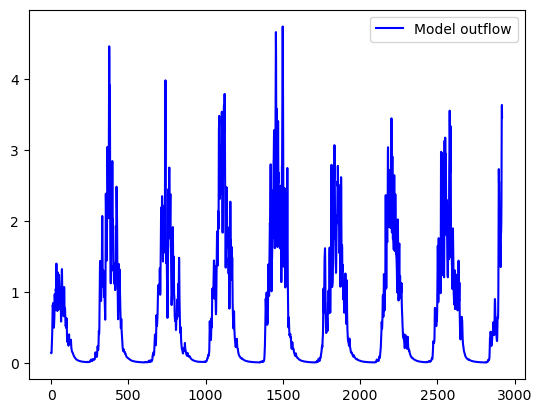

In [7]:
plt.plot(range(len(precipitation)), output, color = 'blue', label = 'Model outflow')


plt.legend()
plt.show()